In [29]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Flatten
from sklearn.model_selection import train_test_split
import shap
from preprocessing_functions import *
import tensorflow as tf
import keras
import google.protobuf
import h5py

In [30]:
print(tf.__version__)
print(keras.__version__)
print(shap.__version__)
print(google.protobuf.__version__)
print(h5py.__version__)

2.12.0
2.12.0
0.41.0
4.23.2
2.10.0


In [31]:
edges = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_classes.csv")

In [32]:
edges_by_timestep, features_by_timestep, classes_by_timestep = split_by_time_step(edges, features, classes)
features_num = features.iloc[0].shape[0]
features_num

167

In [33]:
adjacency_map = get_adjacency_map(edges_by_timestep[1])
transactions_out = get_transactions_out_with_adjacency_map(adjacency_map, edges_by_timestep[1].iloc[16]['txId1'], max_depth=10, max_size=1000)
transactions_out

{'txId': 233591710,
 'transaction_trees_out': [{'txId': 234439913,
   'transaction_trees_out': [{'txId': 234441421,
     'transaction_trees_out': [{'txId': 233307261,
       'transaction_trees_out': [{'txId': 234472020,
         'transaction_trees_out': [{'txId': 234472023,
           'transaction_trees_out': [{'txId': 232413175,
             'transaction_trees_out': [{'txId': 230556835,
               'transaction_trees_out': []},
              {'txId': 232413172,
               'transaction_trees_out': [{'txId': 19609789,
                 'transaction_trees_out': []},
                {'txId': 232413178,
                 'transaction_trees_out': [{'txId': 230556838,
                   'transaction_trees_out': 'max_depth reached'},
                  {'txId': 232419645,
                   'transaction_trees_out': 'max_depth reached'}]}]}]}]}]}]},
      {'txId': 234441424,
       'transaction_trees_out': [{'txId': 234441429,
         'transaction_trees_out': [{'txId': 234442451,
        

In [34]:
inversed_adjacency_map = get_inversed_adjacency_map(edges_by_timestep[1])
transactions_in = get_transactions_in_with_inversed_adjacency_map(inversed_adjacency_map, edges_by_timestep[1].iloc[16]['txId1'], max_depth=10, max_size=1000)
transactions_in

{'txId': 233591710,
 'transaction_trees_in': [{'txId': 232007412,
   'transaction_trees_in': [{'txId': 232007419,
     'transaction_trees_in': [{'txId': 232686668,
       'transaction_trees_in': [{'txId': 232686665,
         'transaction_trees_in': [{'txId': 183781611,
           'transaction_trees_in': [{'txId': 232651633,
             'transaction_trees_in': []}]},
          {'txId': 232651633, 'transaction_trees_in': []},
          {'txId': 232665894,
           'transaction_trees_in': [{'txId': 232655296,
             'transaction_trees_in': [{'txId': 230473474,
               'transaction_trees_in': []}]}]},
          {'txId': 232655296,
           'transaction_trees_in': [{'txId': 230473474,
             'transaction_trees_in': []}]}]}]}]}]}]}

In [35]:
root_transaction_id = transactions_in['txId']
print(root_transaction_id)
root_transaction = features_by_timestep[1][features_by_timestep[1][0] == root_transaction_id]
root_transaction

233591710


,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
32,233591710,1,-0.166627,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.157142,...,-0.554681,-0.594691,-0.979074,-0.978556,0.018279,-0.08749,-0.131155,-0.097524,-0.120613,-0.119792


In [36]:
# All the transactions in one timestep appeared on the blockchain within less than three hours between earch other.
# Bitcoin block time is around 10 minutes.
# Lowest ever average block time in one day was about 3.5 minutes.
# Timeseries limieted to 10 transactions before and 10 transactions after the root transaction because preprocessing would take too long.

transactions_timeseries_length = 41
root_transaction_timeseries_index = 20
transactions_timeseries = [[] for i in range(transactions_timeseries_length)]
transactions_timeseries[root_transaction_timeseries_index].append(root_transaction)

In [37]:
transactions_in['transaction_trees_in']

[{'txId': 232007412,
  'transaction_trees_in': [{'txId': 232007419,
    'transaction_trees_in': [{'txId': 232686668,
      'transaction_trees_in': [{'txId': 232686665,
        'transaction_trees_in': [{'txId': 183781611,
          'transaction_trees_in': [{'txId': 232651633,
            'transaction_trees_in': []}]},
         {'txId': 232651633, 'transaction_trees_in': []},
         {'txId': 232665894,
          'transaction_trees_in': [{'txId': 232655296,
            'transaction_trees_in': [{'txId': 230473474,
              'transaction_trees_in': []}]}]},
         {'txId': 232655296,
          'transaction_trees_in': [{'txId': 230473474,
            'transaction_trees_in': []}]}]}]}]}]}]

In [38]:
def add_transaction_trees_in_to_transactions_timeseries(timeseries, transactions_in, features, insertion_start_index):
    if insertion_start_index < 0:
        return  # depth limit reached

    if transactions_in['transaction_trees_in'] == 'max_depth reached' or transactions_in['transaction_trees_in'] == 'max_size reached':
        return

    for tree in transactions_in['transaction_trees_in']:
        tree_features = features[features[0] == tree['txId']]
        timeseries[insertion_start_index].append(tree_features)
        add_transaction_trees_in_to_transactions_timeseries(timeseries, tree, features, insertion_start_index - 1)

In [39]:
add_transaction_trees_in_to_transactions_timeseries(transactions_timeseries, transactions_in, features_by_timestep[1], root_transaction_timeseries_index - 1)
for i in transactions_timeseries:
    print('[', end='')
    for j in i:
        print(f'{j.shape}, ', end='')
    print(']')

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1, 167), ]
[(1, 167), (1, 167), (1, 167), ]
[(1, 167), (1, 167), (1, 167), (1, 167), ]
[(1, 167), ]
[(1, 167), ]
[(1, 167), ]
[(1, 167), ]
[(1, 167), ]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [40]:
def add_transaction_trees_out_to_transactions_timeseries(timeseries, transactions_out, features, insertion_start_index):
    if insertion_start_index >= transactions_timeseries_length:
        return  # depth limit reached

    if transactions_out['transaction_trees_out'] == 'max_depth reached' or transactions_out['transaction_trees_out'] == 'max_size reached':
        return

    for tree in transactions_out['transaction_trees_out']:
        tree_features = features[features[0] == tree['txId']]
        timeseries[insertion_start_index].append(tree_features)
        add_transaction_trees_out_to_transactions_timeseries(timeseries, tree, features, insertion_start_index + 1)

In [41]:
add_transaction_trees_out_to_transactions_timeseries(transactions_timeseries, transactions_out, features, root_transaction_timeseries_index + 1)
for i in transactions_timeseries:
    print('[', end='')
    for j in i:
        print(f'{j.shape}, ', end='')
    print(']')

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(1, 167), ]
[(1, 167), (1, 167), (1, 167), ]
[(1, 167), (1, 167), (1, 167), (1, 167), ]
[(1, 167), ]
[(1, 167), ]
[(1, 167), ]
[(1, 167), ]
[(1, 167), ]
[(1, 167), ]
[(1, 167), (1, 167), ]
[(1, 167), (1, 167), (1, 167), ]
[(1, 167), (1, 167), (1, 167), ]
[(1, 167), (1, 167), (1, 167), ]
[(1, 167), (1, 167), (1, 167), (1, 167), (1, 167), ]
[(1, 167), (1, 167), (1, 167), (1, 167), (1, 167), (1, 167), ]
[(1, 167), (1, 167), (1, 167), (1, 167), (1, 167), (1, 167), (1, 167), ]
[(1, 167), (1, 167), (1, 167), (1, 167), (1, 167), (1, 167), (1, 167), (1, 167), ]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [42]:
transactions_timeseries_summary = pd.DataFrame(np.zeros((transactions_timeseries_length, features_num)))
for i in range(transactions_timeseries_length):
    if len(transactions_timeseries[i]) == 0:
        continue

    transactions_timeseries_summary.loc[i] = pd.concat(transactions_timeseries[i]).mean(axis=0)
    transactions_timeseries_summary.at[i, 0] = len(transactions_timeseries[i])

transactions_timeseries_summary[20:]

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
20,1.0,1.0,-0.166627,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.157142,...,-0.554681,-0.594691,-0.979074,-0.978556,0.018279,-0.08749,-0.131155,-0.097524,-0.120613,-0.119792
21,1.0,1.0,-0.166943,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.157466,...,-0.569626,-0.607306,-0.979074,-0.978556,0.018279,-0.08749,-0.131155,-0.097524,-0.120613,-0.119792
22,2.0,1.0,-0.169647,-0.170427,-0.091383,-0.084451,-0.043875,-0.071071,-0.061584,-0.160556,...,-0.565890,-0.578923,-0.979074,-0.978556,-0.040305,-0.08749,-0.107915,-0.119060,0.699543,0.700804
23,3.0,1.0,-0.168712,-0.166545,-0.461379,0.053118,-0.050491,-0.085048,0.547008,-0.161586,...,-0.562153,-0.584179,-0.572340,-0.571902,-0.020777,-0.08749,-0.115662,-0.111881,0.426158,0.427272
24,3.0,1.0,-0.166878,-0.176039,-1.201369,0.028105,-0.050491,-0.113002,0.547008,-0.159494,...,-0.357893,-0.428596,-0.572340,-0.571902,-0.020777,-0.08749,-0.115662,-0.111881,0.426158,0.427272
25,3.0,1.0,-0.166910,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.157432,...,-0.360384,-0.430698,-0.979074,-0.978556,-0.020777,-0.08749,-0.115662,-0.111881,0.426158,0.427272
26,5.0,1.0,-0.168977,-0.173278,-0.979372,-0.076947,-0.043875,-0.079457,-0.000725,-0.159936,...,-0.548702,-0.561893,-0.490993,-0.490571,-0.028588,-0.08749,-0.112563,-0.114753,0.535512,0.536684
27,6.0,1.0,-0.168758,-0.170862,-1.016371,0.015599,-0.047183,-0.057094,0.242712,-0.160625,...,-0.554681,-0.582077,-0.775707,-0.775229,-0.020777,-0.08749,-0.115662,-0.111881,0.426158,0.427272
28,7.0,1.0,-0.169144,-0.172465,-0.963515,-0.036212,-0.043875,-0.053100,0.025358,-0.160215,...,-0.461802,-0.491069,-0.281815,-0.281435,-0.065412,-0.08749,-0.097955,-0.128290,0.582378,0.583576
29,8.0,1.0,-0.168839,-0.167519,-0.993247,0.037485,-0.048837,-0.081554,0.470934,-0.161395,...,-0.561219,-0.576558,-0.368973,-0.368575,-0.025659,-0.08749,-0.113725,-0.113676,0.494504,0.495655


In [43]:
def get_transaction_timeseries_summary(features, adjacency_map, inversed_adjacency_map, transaction):
    transaction_id = transaction.iloc[0]
    transactions_in = get_transactions_in_with_inversed_adjacency_map(inversed_adjacency_map, transaction_id, max_depth=10, max_size=1000)
    transactions_out = get_transactions_out_with_adjacency_map(adjacency_map, transaction_id, max_depth=10, max_size=1000)

    transactions_timeseries = [[] for i in range(transactions_timeseries_length)]
    transactions_timeseries[root_transaction_timeseries_index].append(transaction)
    add_transaction_trees_in_to_transactions_timeseries(transactions_timeseries, transactions_in, features, root_transaction_timeseries_index - 1)
    add_transaction_trees_out_to_transactions_timeseries(transactions_timeseries, transactions_out, features, root_transaction_timeseries_index + 1)

    transactions_timeseries_summary = pd.DataFrame(np.zeros((transactions_timeseries_length, features_num)))
    for i in range(transactions_timeseries_length):
        if len(transactions_timeseries[i]) == 0:
            continue
    
        transactions_timeseries_summary.loc[i] = pd.concat(transactions_timeseries[i]).mean(axis=0)
        transactions_timeseries_summary.at[i, 0] = len(transactions_timeseries[i])

    return transactions_timeseries_summary

In [44]:
transaction_summaries = []
for timestep in features_by_timestep:
    adjacency_map = get_adjacency_map(edges_by_timestep[timestep])
    inversed_adjacency_map = get_inversed_adjacency_map(edges_by_timestep[timestep])

    index = 0
    for _, transaction in features_by_timestep[timestep].iterrows():
        if index % 10 == 0:
            print(f'\rtime step: {timestep},\tindex: {index}', end='', flush=True)
        index += 1

        transaction_id = transaction.iloc[0]

        # Filter out unknown class
        if classes[classes['txId'] == transaction_id].iloc[0][1] == 'unknown':
            continue

        transactions_timeseries_summary = get_transaction_timeseries_summary(features_by_timestep[timestep], adjacency_map, inversed_adjacency_map, transaction)
        transaction_summaries.append({'id': transaction_id, 'summary': transactions_timeseries_summary})

    print()


time step: 1,	index: 7870
time step: 2,	index: 4540
time step: 3,	index: 6620
time step: 4,	index: 5690
time step: 5,	index: 6800
time step: 6,	index: 4320
time step: 7,	index: 6040
time step: 8,	index: 4450
time step: 9,	index: 4990
time step: 10,	index: 6720
time step: 11,	index: 4290
time step: 12,	index: 2040
time step: 13,	index: 4520
time step: 14,	index: 2020
time step: 15,	index: 3630
time step: 16,	index: 2970
time step: 17,	index: 3380
time step: 18,	index: 1970
time step: 19,	index: 3500
time step: 20,	index: 4290
time step: 21,	index: 3530
time step: 22,	index: 5890
time step: 23,	index: 4160
time step: 24,	index: 4590
time step: 25,	index: 2310
time step: 26,	index: 2520
time step: 27,	index: 1080
time step: 28,	index: 1650
time step: 29,	index: 4270
time step: 30,	index: 2480
time step: 31,	index: 2810
time step: 32,	index: 4520
time step: 33,	index: 3150
time step: 34,	index: 2480
time step: 35,	index: 5500
time step: 36,	index: 6390
time step: 37,	index: 3300
time step:

In [45]:
transaction_summaries[:10]

[{'id': 232438397.0,
  'summary':       0             1             2             3             4    \
  0     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  1     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  2     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  3     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  4     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  5     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  6     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  7     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  8     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  9     0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  10    0.0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
  11    7.0  1.000000e+00 -1.610807e-01 -1.846676e-01 -1.201369e+00   
  12    9.0  1.000000e+00 -1.437907e-01 -1.84

In [46]:
x = []
y = []

for i in transaction_summaries:
    x.append(i['summary'].to_numpy())
    y.append(classes[classes['txId'] == i['id']].iloc[0][1] == '1')

x = np.array(x)
y = np.array(y)

In [47]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=42)

In [48]:
x_train[0].shape

(41, 167)

In [49]:
len(x_train)

36870

In [50]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=64, input_shape=x[0].shape))
rnn_model.add(Dense(units=32, activation='sigmoid'))
rnn_model.add(Dense(units=1, activation='sigmoid'))
rnn_model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                14848     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [51]:
rnn_model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100


2023-07-03 01:37:08.251031: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1009795560 exceeds 10% of free system memory.


1153/1153 [==============================] - 9s 7ms/step - loss: 0.2913 - accuracy: 0.9078 - val_loss: 0.2393 - val_accuracy: 0.9172
Epoch 2/100
1153/1153 [==============================] - 8s 7ms/step - loss: 0.2183 - accuracy: 0.9308 - val_loss: 0.2200 - val_accuracy: 0.9326
Epoch 3/100
1153/1153 [==============================] - 8s 7ms/step - loss: 0.2041 - accuracy: 0.9341 - val_loss: 0.2214 - val_accuracy: 0.9281
Epoch 4/100
1153/1153 [==============================] - 8s 7ms/step - loss: 0.2253 - accuracy: 0.9258 - val_loss: 0.2512 - val_accuracy: 0.9106
Epoch 5/100
1153/1153 [==============================] - 8s 7ms/step - loss: 0.2333 - accuracy: 0.9249 - val_loss: 0.2278 - val_accuracy: 0.9257
Epoch 6/100
1153/1153 [==============================] - 8s 7ms/step - loss: 0.2405 - accuracy: 0.9259 - val_loss: 0.2619 - val_accuracy: 0.9263
Epoch 7/100
1153/1153 [==============================] - 9s 8ms/step - loss: 0.2310 - accuracy: 0.9302 - val_loss: 0.2383 - val_accuracy: 0.92

In [52]:
x_shap = x_test[np.random.choice(x_test.shape[0], 100, replace=False)]
explainer = shap.GradientExplainer(rnn_model, x_shap)
shap_values = explainer.shap_values(x_shap)


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [53]:
shap_values[0].shape

(100, 41, 167)

In [54]:
shap_values_to_display = [i for i in shap_values[0]]

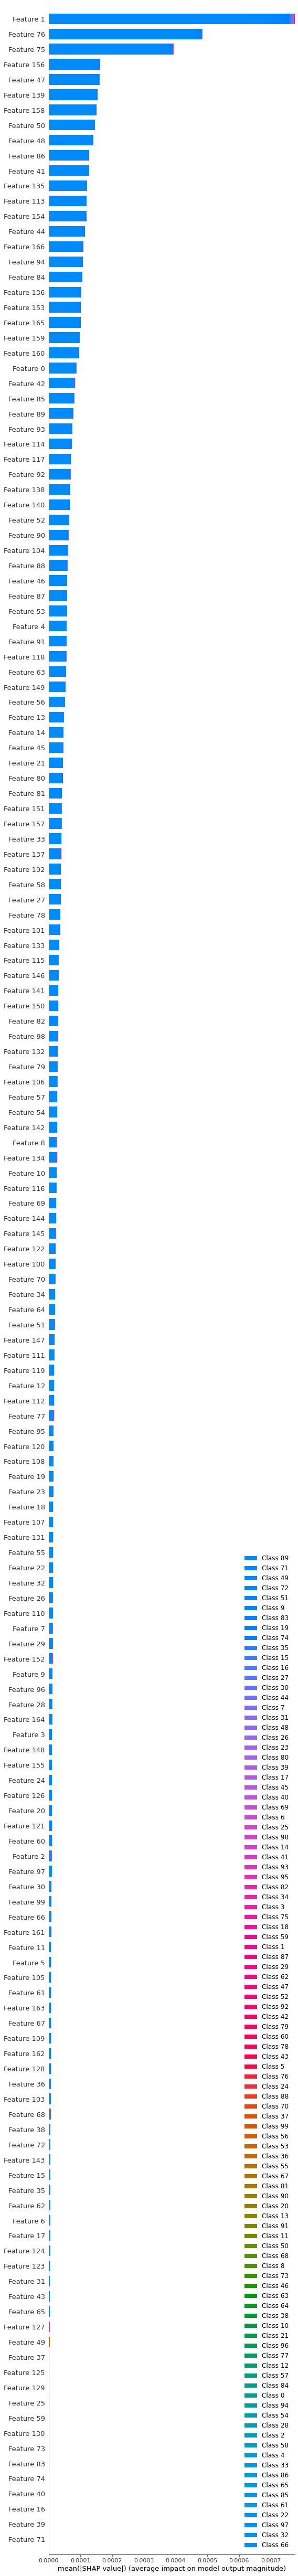

In [55]:
# shap.summary_plot(shap_values[0][0], plot_type='bar')
shap.summary_plot(shap_values_to_display, plot_type='bar', max_display=shap_values_to_display[0].shape[1])